# VAEP
## Phase 1: Setup
### Initialize the Wyscout loader

In [1]:
from socceraction.data.wyscout import WyscoutLoader
from dotenv import load_dotenv
# set authentication credentials as environment variables
import os


load_dotenv()
os.environ["WY_USERNAME"] = os.getenv('WYSCOUT_API_USERNAME')
os.environ["WY_PASSWORD"] = os.getenv('WYSCOUT_API_PASSWORD')
WSC = WyscoutLoader(getter="remote")

### Update the competition_id and season_id if necessary.

In [2]:
competition_id = 43236
season_id = 191743

df_games = WSC.games(competition_id=competition_id, season_id=season_id)
df_games = df_games.set_index("game_id")
print(df_games.head())

         competition_id  season_id           game_date  game_day  \
game_id                                                            
5786229           43236     191743 2025-11-09 17:00:00         1   
5785643           43236     191743 2025-11-07 00:00:00         1   
5785641           43236     191743 2025-11-06 21:00:00         1   
5785336           43236     191743 2025-11-02 20:30:00         1   
5785335           43236     191743 2025-11-02 17:30:00         1   

         home_team_id  away_team_id  
game_id                              
5786229         61739         61555  
5785643         61555         61731  
5785641         61739         61552  
5785336         61555         61549  
5785335         61739         61557  


### Filter to Michigan games

In [3]:
michigan_id = 61553

michigan_games = df_games[
    (df_games['home_team_id'] == michigan_id) |
    (df_games['away_team_id'] == michigan_id)
]
print(michigan_games)

         competition_id  season_id           game_date  game_day  \
game_id                                                            
5733494           43236     191743 2025-10-26 17:00:00        11   
5733479           43236     191743 2025-10-19 17:00:00        10   
5733473           43236     191743 2025-10-16 23:00:00         9   
5733464           43236     191743 2025-10-12 17:00:00         8   
5733449           43236     191743 2025-10-09 23:00:00         7   
5733438           43236     191743 2025-10-04 23:00:00         6   
5733421           43236     191743 2025-09-28 17:00:00         5   
5733406           43236     191743 2025-09-26 00:05:00         4   
5733397           43236     191743 2025-09-21 17:00:00         3   
5733388           43236     191743 2025-09-18 23:00:00         2   
5733376           43236     191743 2025-09-12 23:00:00         1   

         home_team_id  away_team_id  
game_id                              
5733494         61553         61557  
5

### Convert to SPADL format

In [12]:
import socceraction.spadl as spadl
import pandas as pd
import time

all_actions = []
counter = 0

for game_id in df_games.index:
    events = WSC.events(game_id=game_id)
    actions = spadl.wyscout.convert_to_actions(
        events,
        home_team_id=df_games.loc[game_id, 'home_team_id']
    )

    actions['game_id'] = game_id

    all_actions.append(actions)

    if counter % 10 == 0:
        print(f"Converted {counter} games")

    counter += 1
    time.sleep(0.5)

print(f"Converted {counter} games")


df_actions_league = pd.concat(all_actions, ignore_index=True)
print(f"\nTotal actions across all games: {len(df_actions_league)}")

df_actions_league = spadl.add_names(df_actions_league)

Converted 0 games
Converted 10 games
Converted 20 games
Converted 30 games
Converted 40 games
Converted 50 games
Converted 60 games
Converted 70 games
Converted 80 games
Converted 90 games
Converted 100 games
Converted 108 games

Total actions across all games: 135445


## Phase 2: Creating Model
### Create features

In [13]:
from socceraction.vaep import features as fs, labels as lab
import socceraction.spadl.config as spadlconfig

X_list = []

for game_id in df_actions_league['game_id'].unique():
    game_actions = df_actions_league[df_actions_league['game_id'] == game_id].reset_index(drop=True)

    home_team_id = df_games.loc[game_id, 'home_team_id']

    gamestates = fs.gamestates(game_actions, nb_prev_actions=3)
    gamestates = fs.play_left_to_right(gamestates, home_team_id)

    X = pd.concat([
        fs.actiontype_onehot(gamestates),
        fs.bodypart(gamestates),
        fs.result_onehot(gamestates),
        fs.goalscore(gamestates),
        fs.startlocation(gamestates),
        fs.endlocation(gamestates),
        fs.movement(gamestates),
        fs.space_delta(gamestates),
        fs.startpolar(gamestates),
        fs.endpolar(gamestates),
        fs.team(gamestates),
        fs.time_delta(gamestates)
    ], axis=1)

    X_list.append(X)

X = pd.concat(X_list, ignore_index=True)

/Users/wxng/UMWSOC/code/venv/lib/python3.9/site-packages/socceraction/vaep/features.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.shift(i, fill_value=float("nan")).fillna(x.iloc[0])  # noqa: B023
/Users/wxng/UMWSOC/code/venv/lib/python3.9/site-packages/socceraction/vaep/features.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.shift(i, fill_value=float("nan")).fillna(x.iloc[0])  # noqa: B023
/Users/wxng/UMWSOC/code/venv/lib/python3.9/site-packages/socceraction/vaep/features.py:94: FutureWarning: Downcasting object dtype

### Create targets

In [14]:

Y_list = []

for game_id in df_actions_league['game_id'].unique():
    game_actions = df_actions_league[df_actions_league['game_id'] == game_id].reset_index(drop=True)

    Y = pd.concat([
        lab.scores(game_actions, nr_actions=10),
        lab.concedes(game_actions, nr_actions=10),
        lab.goal_from_shot(game_actions)
    ], axis=1)

    Y_list.append(Y)

Y = pd.concat(Y_list, ignore_index=True)

### Train Model

In [15]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, shuffle=True
)

print(f"training set size: {len(X_train)}")
print(f"test set size: {len(X_test)}")

print(f"training scoring model...")
model_scores = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    enable_categorical=True
)
model_scores.fit(X_train, Y_train['scores'])

print(f"scoring model training accuracy: {model_scores.score(X_train, Y_train['scores']):.4f}")
print(f"scoring model test accuracy: {model_scores.score(X_test, Y_test['scores']):.4f}")

print(f"training conceding model...")
model_concedes = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    enable_categorical=True
)
model_concedes.fit(X_train, Y_train['concedes'])

print(f"concedes model training accuracy: {model_concedes.score(X_train, Y_train['concedes']):.4f}")
print(f"concedes model test accuracy: {model_concedes.score(X_test, Y_test['concedes']):.4f}")



training set size: 108356
test set size: 27089
training scoring model...


/Users/wxng/UMWSOC/code/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


scoring model training accuracy: 0.9916
scoring model test accuracy: 0.9888
training conceding model...


/Users/wxng/UMWSOC/code/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


concedes model training accuracy: 0.9982
concedes model test accuracy: 0.9945


## Phase 3: Calculate VAEP
### Find probabilities of scoring and conceding

In [16]:
predictions = pd.DataFrame()
predictions['scores'] = model_scores.predict_proba(X)[:, 1]
predictions['concedes'] = model_concedes.predict_proba(X)[:, 1]

print("Prediction stats:")
print(predictions.describe())

Prediction stats:
              scores      concedes
count  135445.000000  1.354450e+05
mean        0.012812  5.114537e-03
std         0.058487  4.149035e-02
min         0.000002  4.327250e-07
25%         0.001057  2.444975e-04
50%         0.003163  7.137933e-04
75%         0.008785  2.094378e-03
max         0.999386  9.759261e-01


In [17]:
from socceraction.vaep.formula import value

vaep_values = value(
    actions=df_actions_league,
    Pscores=predictions['scores'],
    Pconcedes=predictions['concedes']
)

df_actions = pd.concat([df_actions_league, vaep_values], axis=1)

In [19]:
import socceraction.data.wyscout.loader as ws_loader
from socceraction.data.base import _expand_minute
import pandas as pd

# 1. Define the "Safe" version of the internal function
def _get_minutes_played_safe(teamsData, events):
    # Mapping for match periods
    wyscout_periods = {"1H": 1, "2H": 2, "E1": 3, "E2": 4, "P": 5}
    
    # Get duration of each period
    periods_ts = {i: [0] for i in range(6)}
    for e in events:
        period_id = wyscout_periods.get(e.get("matchPeriod", e.get("match_period")), 1)
        periods_ts[period_id].append(e.get("eventSec", e.get("event_sec", 0)))
    
    periods_duration = [round(max(periods_ts[i]) / 60) for i in range(5) if max(periods_ts[i]) != 0]
    duration = sum(periods_duration)

    playergames = {}
    if isinstance(teamsData, dict):
        teamsData = list(teamsData.values())
        
    for teamData in teamsData:
        formation = teamData.get("formation", {})
        substitutions = formation.get("substitutions", [])
        
        # Initialize starters
        pg = {
            player["playerId"]: {
                "team_id": teamData["teamId"],
                "player_id": player["playerId"],
                "minutes_played": duration,
                "is_starter": True,
            }
            for player in formation.get("lineup", [])
        }

        # Correct minutes for substituted players
        if substitutions != "null" and substitutions is not None:
            for substitution in substitutions:
                expanded_minute_sub = _expand_minute(substitution["minute"], periods_duration)
                
                # Initialize the substitute (PlayerIn)
                pg[substitution["playerIn"]] = {
                    "team_id": teamData["teamId"],
                    "player_id": substitution["playerIn"],
                    "minutes_played": duration - expanded_minute_sub,
                    "is_starter": False,
                }
                
                # THE FIX: Check if the player being subbed out exists in the roster
                if substitution["playerOut"] in pg:
                    pg[substitution["playerOut"]]["minutes_played"] = expanded_minute_sub
        
        playergames.update(pg)
        
    return pd.DataFrame(playergames.values())

# 2. Monkey-patch: Assign our safe function to the loader module
ws_loader._get_minutes_played = _get_minutes_played_safe

print("Successfully overloaded _get_minutes_played. WSC.players() is now safe to use.")

Successfully overloaded _get_minutes_played. WSC.players() is now safe to use.


In [20]:
print("Loading player and team data...")

all_players = []
all_teams = []

for game_id in df_games.index:
    # Get players for this game
    game_players = WSC.players(game_id=game_id)
    game_players['game_id'] = game_id
    all_players.append(game_players)
    
    # Get teams for this game
    game_teams = WSC.teams(game_id=game_id)
    game_teams['game_id'] = game_id
    all_teams.append(game_teams)

df_players = pd.concat(all_players, ignore_index=True)
df_teams = pd.concat(all_teams, ignore_index=True)

# Remove duplicate players (same player can appear in multiple games)
df_players = df_players.drop_duplicates(subset=['player_id'])
df_teams = df_teams.drop_duplicates(subset=['team_id'])

print(f"Total unique players in Big 10: {len(df_players)}")
print(f"Total unique teams in Big 10: {len(df_teams)}")

Loading player and team data...
Total unique players in Big 10: 389
Total unique teams in Big 10: 18


### Calculate VAEP values

In [21]:
print("="*60)
print("Aggregating VAEP for all Big 10 players...")
print("="*60)

# Group by player_id and aggregate VAEP values
player_vaep = df_actions.groupby('player_id').agg({
    'vaep_value': ['sum', 'mean', 'count'],
    'offensive_value': 'sum',
    'defensive_value': 'sum',
    'team_id': 'first'  # Get the team_id for each player
}).reset_index()

# Flatten column names
player_vaep.columns = ['player_id', 'vaep_total', 'vaep_mean', 'action_count', 
                        'offensive_total', 'defensive_total', 'team_id']

# Merge with player names
player_vaep = player_vaep.merge(
    df_players[['player_id', 'player_name']], 
    on='player_id', 
    how='left'
)

# Merge with team names
player_vaep = player_vaep.merge(
    df_teams[['team_id', 'team_name']], 
    on='team_id', 
    how='left'
)

# Sort by total VAEP value
player_vaep_all = player_vaep.sort_values('vaep_total', ascending=False)

print(f"\nTotal players with VAEP ratings: {len(player_vaep_all)}")

Aggregating VAEP for all Big 10 players...

Total players with VAEP ratings: 390


## Phase 4: Results

In [22]:
print("="*60)
print("TOP 20 PLAYERS IN BIG 10 BY VAEP")
print("="*60)

top_20_big10 = player_vaep_all.head(20)
print(top_20_big10[['player_name', 'team_name', 'vaep_total', 'offensive_total', 
                     'defensive_total', 'action_count']])

TOP 20 PLAYERS IN BIG 10 BY VAEP
            player_name                                    team_name  \
151        Millie Greer                     Iowa Hawkeyes University   
58    Emerson  Sargeant           Michigan State Spartans University   
206          Iba Oching                     Iowa Hawkeyes University   
281     Samantha Maroni           Michigan State Spartans University   
53       Hailey Baumann                 Wisconsin Badgers University   
166        Renee Watson           Michigan State Spartans University   
17       Miah Schueller                     Iowa Hawkeyes University   
184        Samiah Shell                Washington Huskies University   
13            Adee Boer                 Wisconsin Badgers University   
357          Marcia Ojo           Rutgers Scarlet Knights University   
134    Amanda Schlueter               Ohio State Buckeyes University   
11         Jayde Holley                      Oregon Ducks University   
167       Megan Norkett        

In [23]:
print("="*60)
print("MICHIGAN PLAYERS RANKED BY VAEP")
print("="*60)

michigan_players = player_vaep_all[player_vaep_all['team_id'] == michigan_id].copy()
michigan_players = michigan_players.sort_values('vaep_total', ascending=False)

print(f"\nTotal Michigan players: {len(michigan_players)}")
print("\nAll Michigan players ranked by VAEP:")
print(michigan_players[['player_name', 'vaep_total', 'offensive_total', 
                        'defensive_total', 'action_count']])

MICHIGAN PLAYERS RANKED BY VAEP

Total Michigan players: 22

All Michigan players ranked by VAEP:
                    player_name  vaep_total  offensive_total  defensive_total  \
66                Kali  Burrell    2.789864         2.591525         0.198340   
64                  Jenna Lang     2.787778         4.122771        -1.334993   
32                 Vickie Jones    2.390067         1.673172         0.716895   
148             Gabrielle Prych    1.943768         1.341894         0.601874   
61               Aniyah  League    1.561481         1.705500        -0.144019   
147             Campbell Jewell    1.458832         1.737096        -0.278264   
232                 Elle  Ervin    1.345635         1.211084         0.134552   
283                 Ellie  Fife    1.057822         1.336177        -0.278355   
154  Stella Lucia Tapia Jimenez    0.676815         0.416512         0.260303   
229                 Adi  Walick    0.555693         0.561671        -0.005978   
230        

In [24]:
print("="*60)
print("CALCULATING PER-90 RATINGS")
print("="*60)

# Estimate playing time from action timestamps (approximate)
game_player_max = df_actions.groupby(['player_id', 'game_id'])['time_seconds'].max().reset_index()

# 2. Sum those game-maxes to get total season minutes
player_minutes = game_player_max.groupby('player_id').agg({
    'time_seconds': 'sum',
    'game_id': 'count'
}).reset_index()

# 3. Rename columns and convert to minutes
player_minutes.columns = ['player_id', 'total_time_seconds', 'games_played']
player_minutes['estimated_minutes'] = player_minutes['total_time_seconds'] / 60

# --- Now continue with your merge and filtering ---
player_vaep_with_time = player_vaep_all.merge(
    player_minutes[['player_id', 'estimated_minutes', 'games_played']], 
    on='player_id'
)

# Calculate per 90
player_vaep_with_time['vaep_per90'] = (
    player_vaep_with_time['vaep_total'] / player_vaep_with_time['estimated_minutes'] * 90
)
player_vaep_with_time['offensive_per90'] = (
    player_vaep_with_time['offensive_total'] / player_vaep_with_time['estimated_minutes'] * 90
)
player_vaep_with_time['defensive_per90'] = (
    player_vaep_with_time['defensive_total'] / player_vaep_with_time['estimated_minutes'] * 90
)

# Filter for players with at least 90 minutes (approximately 1 full games)
qualified_players = player_vaep_with_time[
    player_vaep_with_time['estimated_minutes'] >= 90
].copy()

# Sort by per-90 rating
qualified_players = qualified_players.sort_values('vaep_per90', ascending=False)

print("\nTop 20 Big 10 players by VAEP per 90 (min. 90 minutes):")
print(qualified_players.head(20)[['player_name', 'team_name', 'vaep_per90', 
                                   'offensive_per90', 'defensive_per90', 
                                   'estimated_minutes', 'games_played']])

CALCULATING PER-90 RATINGS

Top 20 Big 10 players by VAEP per 90 (min. 90 minutes):
          player_name                                    team_name  \
76   Mélia Bourdoncle               Purdue Boilermakers University   
3     Samantha Maroni           Michigan State Spartans University   
8           Adee Boer                 Wisconsin Badgers University   
2          Iba Oching                     Iowa Hawkeyes University   
0        Millie Greer                     Iowa Hawkeyes University   
13        Ella Rudney              Nebraska Cornhuskers University   
9          Marcia Ojo           Rutgers Scarlet Knights University   
4      Hailey Baumann                 Wisconsin Badgers University   
10   Amanda Schlueter               Ohio State Buckeyes University   
6      Miah Schueller                     Iowa Hawkeyes University   
1   Emerson  Sargeant           Michigan State Spartans University   
11       Jayde Holley                      Oregon Ducks University   
5     

In [25]:
# Michigan players ranked by per-90
michigan_qualified = qualified_players[qualified_players['team_id'] == michigan_id].copy()
print(f"Michigan players by VAEP per 90 (min. 90 minutes):")
print(michigan_qualified[['player_name', 'vaep_per90', 'offensive_per90', 
                          'defensive_per90', 'estimated_minutes', 'games_played']])

Michigan players by VAEP per 90 (min. 90 minutes):
                    player_name  vaep_per90  offensive_per90  defensive_per90  \
31                Kali  Burrell    0.508309         0.472172         0.036137   
32                  Jenna Lang     0.446071         0.659683        -0.213612   
47                 Vickie Jones    0.394184         0.275949         0.118234   
62              Gabrielle Prych    0.326908         0.225683         0.101225   
86               Aniyah  League    0.265927         0.290454        -0.024527   
92              Campbell Jewell    0.236959         0.282157        -0.045199   
102                 Elle  Ervin    0.219563         0.197608         0.021954   
117                 Ellie  Fife    0.169096         0.213592        -0.044496   
155  Stella Lucia Tapia Jimenez    0.133900         0.082402         0.051498   
170                 Adi  Walick    0.128754         0.130139        -0.001385   
179            Ella  Jablinskey    0.079516         0.2800

In [26]:
print("="*60)
print("MICHIGAN PLAYERS IN BIG 10 CONTEXT")
print("="*60)

# Add conference rank to all players
player_vaep_all['big10_rank'] = range(1, len(player_vaep_all) + 1)

# Filter to Michigan and show their conference ranking
michigan_with_rank = player_vaep_all[player_vaep_all['team_id'] == michigan_id].copy()
print("\nMichigan players with Big 10 ranking:")
print(michigan_with_rank[['big10_rank', 'player_name', 'vaep_total', 
                          'offensive_total', 'defensive_total', 'action_count']].head(15))

# Count how many Michigan players are in top 50, 100, etc.
top_50_michigan = len(michigan_with_rank[michigan_with_rank['big10_rank'] <= 50])
top_100_michigan = len(michigan_with_rank[michigan_with_rank['big10_rank'] <= 100])

print(f"\nMichigan players in Big 10 Top 50: {top_50_michigan}")
print(f"Michigan players in Big 10 Top 100: {top_100_michigan}")

MICHIGAN PLAYERS IN BIG 10 CONTEXT

Michigan players with Big 10 ranking:
     big10_rank                 player_name  vaep_total  offensive_total  \
66           32               Kali  Burrell    2.789864         2.591525   
64           33                 Jenna Lang     2.787778         4.122771   
32           48                Vickie Jones    2.390067         1.673172   
148          63             Gabrielle Prych    1.943768         1.341894   
61           87              Aniyah  League    1.561481         1.705500   
147          93             Campbell Jewell    1.458832         1.737096   
232         103                 Elle  Ervin    1.345635         1.211084   
283         118                 Ellie  Fife    1.057822         1.336177   
154         156  Stella Lucia Tapia Jimenez    0.676815         0.416512   
229         171                 Adi  Walick    0.555693         0.561671   
230         180            Ella  Jablinskey    0.468367         1.649322   
143         18

In [38]:
# Save all Big 10 player ratings
# player_vaep_all.to_csv('big10_player_vaep_rankings.csv', index=False)

# Save Michigan-only ratings
# michigan_players.to_csv('michigan_player_vaep_rankings.csv', index=False)

# Save qualified players (per-90)
qualified_players.to_csv('big10_player_vaep_per90_rankings.csv', index=False)

print("="*60)
print("Results saved to:")
# print("  - big10_player_vaep_rankings.csv (all Big 10 players)")
# print("  - michigan_player_vaep_rankings.csv (Michigan only)")
print("  - big10_player_vaep_per90_rankings.csv (per-90 ratings)")
print("="*60)

Results saved to:
  - big10_player_vaep_per90_rankings.csv (per-90 ratings)


# xT
## Phase 1: Setup
### Orient actions left-to-right

In [28]:
# Convert all actions to play left-to-right for each game
df_actions_ltr_list = []

for game_id in df_actions['game_id'].unique():
    game_actions = df_actions[df_actions['game_id'] == game_id].copy()
    home_team_id = df_games.loc[game_id, 'home_team_id']
    
    # Convert to left-to-right
    game_actions_ltr = spadl.play_left_to_right(game_actions, home_team_id)
    df_actions_ltr_list.append(game_actions_ltr)

df_actions_ltr = pd.concat(df_actions_ltr_list, ignore_index=True)
print(f"Converted {len(df_actions_ltr)} actions to left-to-right orientation")

Converted 135445 actions to left-to-right orientation


## Phase 2: Create xT model

In [29]:
import socceraction.xthreat as xthreat

print("="*60)
print("TRAINING xT MODEL ON BIG 10 DATA")
print("="*60)

# Train xT model with 16 x 12 grid
xT_model = xthreat.ExpectedThreat(l=16, w=12)
print("Training xT model on all Big 10 actions...")
xT_model.fit(df_actions_ltr)

print("\nxT model trained successfully!")
print(f"Grid size: 16 x 12 zones")
print(f"Trained on {len(df_actions_ltr)} actions")

# Get only successful move actions (passes, dribbles, crosses that succeeded)
df_mov_actions = xthreat.get_successful_move_actions(df_actions_ltr)

print(f"Total actions: {len(df_actions_ltr)}")
print(f"Successful move actions: {len(df_mov_actions)}")
print(f"Percentage of actions valued by xT: {len(df_mov_actions)/len(df_actions_ltr)*100:.1f}%")

# Calculate xT values
df_mov_actions["xT_value"] = xT_model.rate(df_mov_actions)

print("\nxT value statistics:")
print(df_mov_actions["xT_value"].describe())

# Add xT values back to the original actions dataframe
df_actions_ltr['xT_value'] = 0.0  # Initialize all actions with 0
df_actions_ltr.loc[df_mov_actions.index, 'xT_value'] = df_mov_actions['xT_value'].values

# Show top actions by xT
print("\nTop 20 actions by xT value:")
top_xt_actions = df_actions_ltr.nlargest(20, 'xT_value')
print(top_xt_actions[['game_id', 'type_name', 'start_x', 'start_y', 'end_x', 'end_y', 'xT_value']])

TRAINING xT MODEL ON BIG 10 DATA
Training xT model on all Big 10 actions...
# iterations:  22

xT model trained successfully!
Grid size: 16 x 12 zones
Trained on 135445 actions
Total actions: 135445
Successful move actions: 78698
Percentage of actions valued by xT: 58.1%

xT value statistics:
count    78698.000000
mean         0.002355
std          0.015698
min         -0.223369
25%         -0.000835
50%          0.000539
75%          0.002796
max          0.221164
Name: xT_value, dtype: float64

Top 20 actions by xT value:
        game_id type_name  start_x  start_y   end_x  end_y  xT_value
126288  5733377      pass    70.35    48.28   98.70  34.68  0.221164
121325  5733387     cross    73.50     7.48   99.75  34.68  0.220056
74164   5733438     cross    80.85     5.44  101.85  36.04  0.219743
38639   5733475     cross   103.95    58.48  100.80  37.40  0.217195
86906   5733417     cross    99.75    60.52  102.90  34.00  0.217195
133033  5733372     cross    99.75    57.80  101.85  38.

## Phase 3: Results

In [30]:
print("="*60)
print("AGGREGATING xT FOR ALL BIG 10 PLAYERS")
print("="*60)

# Group by player_id and aggregate xT values
player_xt = df_actions_ltr.groupby('player_id').agg({
    'xT_value': ['sum', 'mean', 'count'],
    'team_id': 'first'
}).reset_index()

# Flatten column names
player_xt.columns = ['player_id', 'xT_total', 'xT_mean', 'action_count', 'team_id']

# Merge with player names
player_xt = player_xt.merge(
    df_players[['player_id', 'player_name']], 
    on='player_id', 
    how='left'
)

# Merge with team names
player_xt = player_xt.merge(
    df_teams[['team_id', 'team_name']], 
    on='team_id', 
    how='left'
)

# Sort by total xT value
player_xt_all = player_xt.sort_values('xT_total', ascending=False)

print(f"\nTotal players with xT ratings: {len(player_xt_all)}")

AGGREGATING xT FOR ALL BIG 10 PLAYERS

Total players with xT ratings: 390


In [31]:
print("="*60)
print("TOP 20 PLAYERS IN BIG 10 BY xT")
print("="*60)

top_20_xt = player_xt_all.head(20)
print(top_20_xt[['player_name', 'team_name', 'xT_total', 'xT_mean', 'action_count']])

TOP 20 PLAYERS IN BIG 10 BY xT
            player_name                                    team_name  \
112    Ella Grace Ottey                 Wisconsin Badgers University   
241         Ava  Goodin             Northwestern Wildcats University   
17       Miah Schueller                     Iowa Hawkeyes University   
11         Jayde Holley                      Oregon Ducks University   
300      Price  Loposer                     Iowa Hawkeyes University   
66        Kali  Burrell            University of Michigan Wolverines   
22          Emma Egizii  University of California Los Angeles Bruins   
329      Audrey Alberts             Northwestern Wildcats University   
33        Lauryn Anglim              Nebraska Cornhuskers University   
306       Kayla  Briggs           Michigan State Spartans University   
64          Jenna Lang             University of Michigan Wolverines   
187       Mia McSweeney               Ohio State Buckeyes University   
378       Kiara Gilmore          

In [32]:
print("="*60)
print("MICHIGAN PLAYERS RANKED BY xT")
print("="*60)

michigan_xt = player_xt_all[player_xt_all['team_id'] == michigan_id].copy()
michigan_xt = michigan_xt.sort_values('xT_total', ascending=False)

print(f"\nTotal Michigan players: {len(michigan_xt)}")
print("\nAll Michigan players ranked by xT:")
print(michigan_xt[['player_name', 'xT_total', 'xT_mean', 'action_count']])

MICHIGAN PLAYERS RANKED BY xT

Total Michigan players: 22

All Michigan players ranked by xT:
                    player_name  xT_total   xT_mean  action_count
66                Kali  Burrell  2.080556  0.004623           450
64                  Jenna Lang   1.888975  0.003479           543
147             Campbell Jewell  1.365843  0.001772           771
230            Ella  Jablinskey  1.250398  0.003223           388
229                 Adi  Walick  0.781262  0.002703           289
283                 Ellie  Fife  0.426647  0.000741           576
42                 Sophie Homan  0.388902  0.001057           368
32                 Vickie Jones  0.372975  0.000959           389
143               Lilley Bosley  0.343618  0.000697           493
154  Stella Lucia Tapia Jimenez  0.227169  0.001033           220
61               Aniyah  League  0.205138  0.000492           417
233              Erin  Junkmann  0.177470  0.001868            95
148             Gabrielle Prych  0.125143  0.000

In [33]:
print("="*60)
print("CALCULATING xT PER-90 RATINGS")
print("="*60)

# Merge with playing time data (reuse from VAEP analysis)
player_xt_with_time = player_xt_all.merge(
    player_minutes[['player_id', 'estimated_minutes', 'games_played']], 
    on='player_id'
)

# Calculate per 90
player_xt_with_time['xT_per90'] = (
    player_xt_with_time['xT_total'] / player_xt_with_time['estimated_minutes'] * 90
)

# Filter for players with at least 270 minutes
qualified_players_xt = player_xt_with_time[
    player_xt_with_time['estimated_minutes'] >= 270
].copy()

qualified_players_xt = qualified_players_xt.sort_values('xT_per90', ascending=False)

print("\nTop 20 Big 10 players by xT per 90 (min. 270 minutes):")
print(qualified_players_xt.head(20)[['player_name', 'team_name', 'xT_per90', 
                                      'xT_total', 'estimated_minutes', 'games_played']])

# Michigan players
michigan_qualified_xt = qualified_players_xt[qualified_players_xt['team_id'] == michigan_id].copy()
print("\nMichigan Players by xT per 90 (min. 270 minutes):")
print(michigan_qualified_xt[['player_name', 'xT_per90', 'xT_total', 
                              'estimated_minutes', 'games_played']])

CALCULATING xT PER-90 RATINGS

Top 20 Big 10 players by xT per 90 (min. 270 minutes):
         player_name                                    team_name  xT_per90  \
0   Ella Grace Ottey                 Wisconsin Badgers University  0.509460   
1        Ava  Goodin             Northwestern Wildcats University  0.458240   
2     Miah Schueller                     Iowa Hawkeyes University  0.450152   
5      Kali  Burrell            University of Michigan Wolverines  0.379074   
3       Jayde Holley                      Oregon Ducks University  0.363144   
27      Lily  Boyden  University of California Los Angeles Bruins  0.343398   
4     Price  Loposer                     Iowa Hawkeyes University  0.317735   
11     Mia McSweeney               Ohio State Buckeyes University  0.308017   
8      Lauryn Anglim              Nebraska Cornhuskers University  0.303399   
10       Jenna Lang             University of Michigan Wolverines  0.302254   
6        Emma Egizii  University of Californi

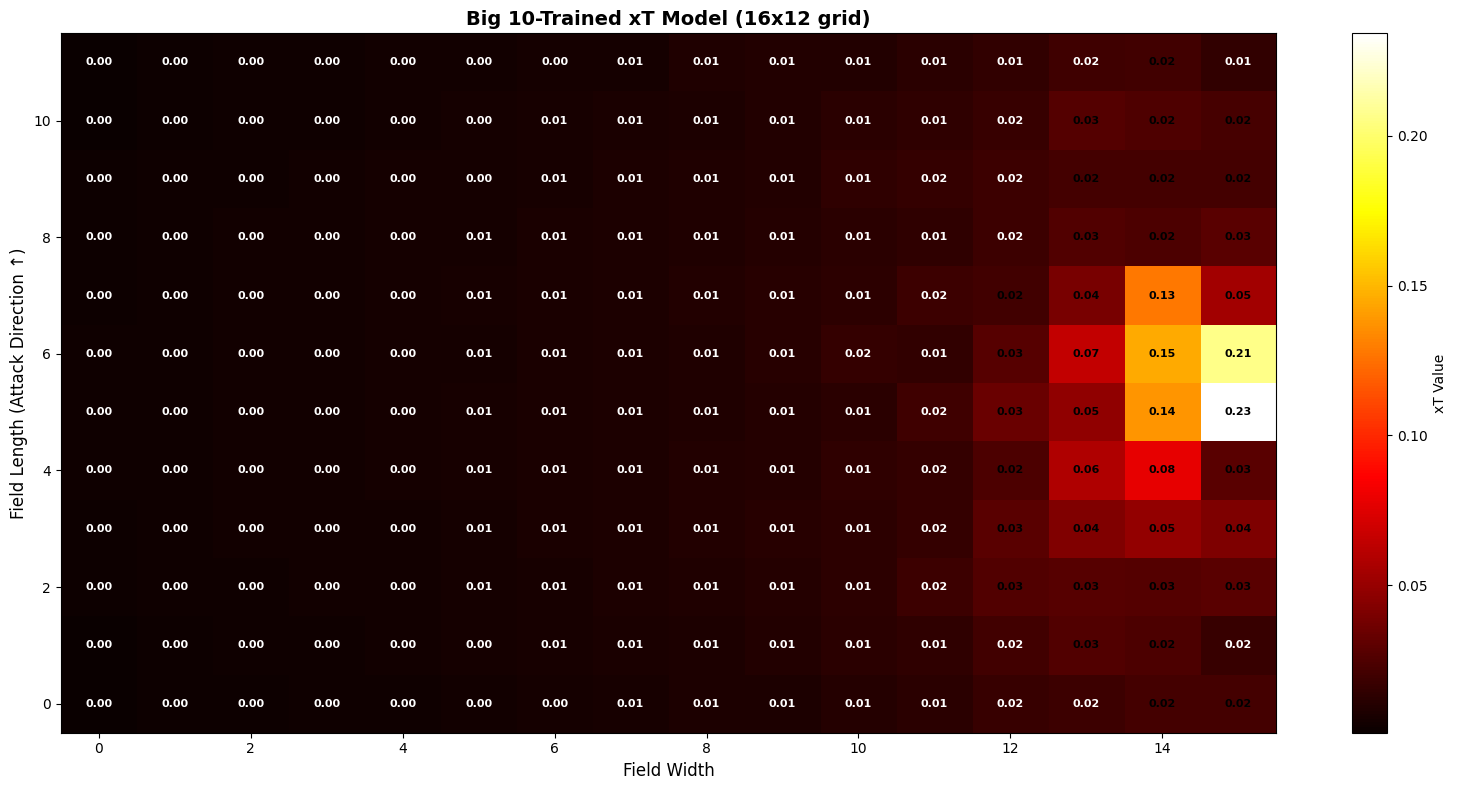


xT heatmap saved as 'xt_heatmap_big10.png'
Hotter (red) zones = Higher threat value
Cooler (dark) zones = Lower threat value
Values shown to 2 decimal places in each zone

Field orientation:
  - Bottom = Own goal
  - Top = Opponent's goal
  - Center (vertically) = Highest threat zones near opponent's box


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the xT grid
fig, ax = plt.subplots(figsize=(16, 8))

# Don't transpose - xT grid is already in correct orientation
# Rows = field length (0 to 105m), Columns = field width (0 to 68m)
im = ax.imshow(xT_model.xT, cmap='hot', origin='lower', aspect='auto')
ax.set_title('Big 10-Trained xT Model (16x12 grid)', fontsize=14, fontweight='bold')
ax.set_xlabel('Field Width', fontsize=12)
ax.set_ylabel('Field Length (Attack Direction ↑)', fontsize=12)
plt.colorbar(im, ax=ax, label='xT Value')

# Add text annotations showing the xT value in each zone
for i in range(xT_model.xT.shape[0]):  # Field length (rows)
    for j in range(xT_model.xT.shape[1]):  # Field width (columns)
        value = xT_model.xT[i, j]
        # Choose text color based on background (white for dark, black for light)
        text_color = 'white' if value < 0.02 else 'black'
        ax.text(j, i, f'{value:.2f}', 
                ha='center', va='center', 
                color=text_color, 
                fontsize=8, 
                fontweight='bold')

plt.tight_layout()
plt.savefig('xt_heatmap_big10.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nxT heatmap saved as 'xt_heatmap_big10.png'")
print("Hotter (red) zones = Higher threat value")
print("Cooler (dark) zones = Lower threat value")
print("Values shown to 2 decimal places in each zone")
print("\nField orientation:")
print("  - Bottom = Own goal")
print("  - Top = Opponent's goal")
print("  - Center (vertically) = Highest threat zones near opponent's box")

In [35]:
# Save xT rankings
player_xt_all.to_csv('big10_player_xt_rankings.csv', index=False)
michigan_xt.to_csv('michigan_player_xt_rankings.csv', index=False)
qualified_players_xt.to_csv('big10_player_xt_per90_rankings.csv', index=False)

print("="*60)
print("xT Results saved to:")
# print("  - big10_player_xt_rankings.csv (all Big 10 players)")
# print("  - michigan_player_xt_rankings.csv (Michigan only)")
print("  - big10_player_xt_per90_rankings.csv (per-90 ratings)")
print("  - xt_heatmap_big10.png (visualization)")
print("="*60)

xT Results saved to:
  - big10_player_xt_per90_rankings.csv (per-90 ratings)
  - xt_heatmap_big10.png (visualization)
